# Capstone Project - Iowa Liquor Retail Sales (Week 2)
### Applied Data Science Capstone by IBM / Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
    * [Weather data](#weather)
    * [Feature engineering](#feature_engineering)
    * [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

I will perform an analysis of a publicly available [data set](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy) on liquor retail sales in the state of Iowa, U.S., to try and gain some insights on some of the most common retail problems. Retailers often want to forecast their demand in order to predict when and how much goods should be stocked.

Analysis of this data set can provide insights into the habits of alcohol consumption in Iowa. They might provide liquor stores with more accurate information about their demand and help them better control their stocks; and they might help distributors optimize their delivery routes by predicting the demand days ahead and thus preventing over- or under-stocking of different types of alcohols (supply-chain problems).

For this project, I will assume the role of owner of a liquor store in Iowa, and it is time to reorder inventory. Before I do so, I would like to get better idea of which products are most popular so that I order the right amounts.

Using the visualisation tool on the Iowa government page, I had generated a plot of sales made by store name, and have decided to investigate the sales of the store that reported the most sales for the period for which the data is available, and that is the store `"Hy-Vee #3 / BDI / Des Moines"` in the `Polk` country, address: `"3221 SE 14TH ST"` (geographical point: `POINT(41.554101 -93.596754)`) which reported over `160K` sales between `2012-2020`.

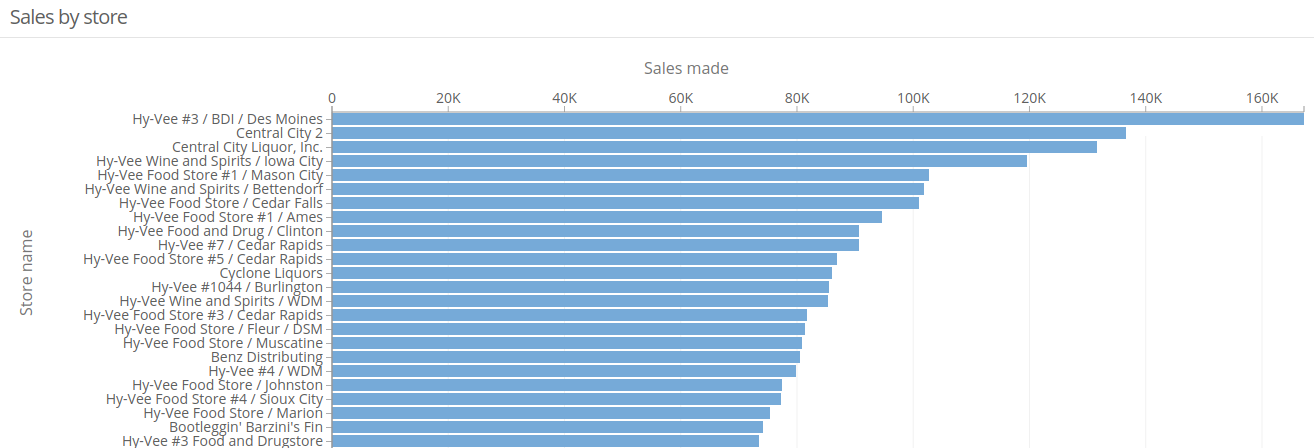!

## Introduction: Data <a name="data"></a>

The original data set contains 24 attributes much of whom are of no interest to us, therefore I will project the initial set to only three columns: `Date` - day the sale was made, `Item Description` - which liquor brand was bought, and `Bottles Sold` - the target variable we are trying to predict.

In [ ]:
import pandas as pd
import numpy as np

csv_filepath = '<FILEPATH>'
column_dtypes = {'Date': str,
              'Item Description': str,
              'Bottles Sold': np.int64}

store_sales_data = pd.read_csv(filepath_or_buffer=csv_filepath, 
                     delimiter=',',
                     usecols=column_dtypes.keys(), 
                     dtype=column_dtypes, 
                     parse_dates=['Date'])
store_sales_data['Date'] = pd.to_datetime(store_sales_data['Date']) # cast the `Date` column to `datetime`
store_sales_data

,Date,Item Description,Bottles Sold
0,2012-08-27,Uv Ivory (vanilla) Vodka,12
1,2012-10-04,Dekuyper Peachtree,72
2,2015-04-23,Absolut Mandrin,12
3,2013-12-12,Dekuyper Hot Damn!,12
4,2014-06-02,Paramount White Rum,6
...,...,...,...
167228,2014-07-07,Smirnoff Sorbet Light Raspberry Pomegranate,1
167229,2012-05-09,Bartenders Hot Sex,1
167230,2013-10-10,Bacardi Wolf Berry,1
167231,2015-05-21,Bacardi O,36


To enhance our predictive power, we are going to incorporate weather data into our analysis. [NOAA's Global Historical Climatology Network (GHCN)](https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00861) contains complex weather data that might help us. It provides weather observation from more than 11K stations around the world, and for some of its stations the data goes back to year 1763!

In our scenario, we would like to obtain some weather parameters from the store's nearest weather stations.

First, we will obtain a list of weather stations that are in 50 km radius from the store. Then, we will compare that list with the weather data for the period 2012-2020, so that we are sure that the stations are still operating.

### Weather data<a name='weather'></a>

The weather data is scattered throughout many files, and their structure is a bit messy. If you want to know more about the structuring of the files, I would kindly refer you to read the `readme` file on this [link](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) and look over all the data files [here](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/). The `ghcnd-stations.txt` file is csv-like file that contains information about the weather stations and their metadata. For our purpouses, we just need the station's code and coordinates (first three columns, separated by different number of spaces).

In [ ]:
store_location = (41.554101, -93.596754) # lat, long
import io
station_locations_filepath = '<FILEPATH>'
lines = io.open(station_locations_filepath, encoding='UTF-8').read().strip().split('\n')
data = list()
for line in lines:
    splitted = line.split(' ') # split line on empty spaces
    splitted = [x for x in splitted if x != ''] # filter out empty strings
    data.append(splitted[:3]) # get first three parts: station code, lat coord, long coord
station_locations = pd.DataFrame(data=data, columns=['Station Code', 'Latitude', 'Longitude'])
station_locations

,Station Code,Latitude,Longitude
0,ACW00011604,17.1167,-61.7833
1,ACW00011647,17.1333,-61.7833
2,AE000041196,25.3330,55.5170
3,AEM00041194,25.2550,55.3640
4,AEM00041217,24.4330,54.6510
...,...,...,...
115077,ZI000067969,-21.0500,29.3670
115078,ZI000067975,-20.0670,30.8670
115079,ZI000067977,-21.0170,31.5830
115080,ZI000067983,-20.2000,32.6160


Once we have our data in the proper format, we can filter out the station codes that are within radius to our store.

In [ ]:
from geopy.distance import distance

radius = 50 #km
stations_within_radius = [(row[0], distance(store_location, (float(row[1]), float(row[2]))).km) 
                          for row in station_locations.values 
                          if distance(store_location, (float(row[1]), float(row[2]))).km < radius]
stations_within_radius = pd.DataFrame(data=stations_within_radius, columns=['Station Code', 'Distance (km)'])
stations_within_radius

,Station Code,Distance (km)
0,US1IABN0009,39.630102
1,US1IABN0013,49.540551
2,US1IADL0001,31.437682
3,US1IADL0004,34.309993
4,US1IADL0005,24.139138
...,...,...
92,USC00139132,44.119406
93,USR0000INEA,28.267976
94,USW00014933,5.209395
95,USW00054902,25.959069


There are 97 weather stations within 50km radius of the store. Let us now check how many of them are active in the period of 2012-2020 and have recorded the weather attributes of interest to us. Upon examining the `ghcnd-inventory` file in the data set, we will filter the weather stations active in period 2012-2020 who have recorded the:

- Maximum temperature for the day (TMAX flag)
- Minimum temperature for the day (TMIN flag)
- Amount of snow fall (SNOW flag)
- Amount of precipitation (PRCP flag)

This information is contained in the `inventory` data set. For each station, it records the `first` and `last` year of measuring each `element`. We would require that each nearby station has records for all of these four elements and that their `first` year is less than `2012`, while the latest year is `2020`.

So, first we read the station inventory.

In [ ]:
inventory_filepath = '<FILEPATH>'
inventory_df_column_names = ['Station Code', 'Latitude', 'Longitude', 'Element', 'First Year', 'Last Year']
lines = io.open(inventory_filepath, encoding='UTF-8').read().strip().split('\n')
data = list()
# data = list()
for line in lines:
    splitted = line.split(' ') # split line on empty spaces
    splitted = [x for x in splitted if x != ''] # filter out empty strings
#     print (len(splitted))
    data.append(splitted)
inventory_df = pd.DataFrame(data=data, columns=inventory_df_column_names)

Next, we will query this data set to consider only the stations that are nearby our store, and that have recorded the weather elements for the period of interest.

In [ ]:
# define query parameters
weather_elements = ['TMAX', 'TMIN', 'SNOW', 'PRCP']
first_year = '2012'
last_year = '2020'
nearby_station_codes = list(stations_within_radius['Station Code'])

# query the dataframe
inventory_df.query('`Station Code` in @nearby_station_codes & \
                        `First Year` <= @first_year & \
                        `Last Year` == @last_year & \
                        `Element` in @weather_elements', inplace=True) # modify the original inventory data set

inventory_df

,Station Code,Latitude,Longitude,Element,First Year,Last Year
227245,US1IADL0017,41.7392,-93.9635,PRCP,1998,2020
227249,US1IADL0018,41.6085,-93.8736,PRCP,2012,2020
228040,US1IAMD0003,41.4964,-94.1599,PRCP,1998,2020
228041,US1IAMD0003,41.4964,-94.1599,SNOW,1998,2020
228167,US1IAPK0003,41.6066,-93.6956,PRCP,2006,2020
...,...,...,...,...,...,...
676789,USW00054902,41.5561,-93.2856,PRCP,2004,2020
685252,USW00094989,41.9922,-93.6217,TMAX,1996,2020
685253,USW00094989,41.9922,-93.6217,TMIN,1996,2020
685254,USW00094989,41.9922,-93.6217,PRCP,1998,2020


This is still not our final list of stations, as some of them may have not recorded **all** of the weather attributes. To further filter our list, and obtain the final result, we group the `inventory` by `Station Code` and request that it has a length of `4`, i.e. the number of elements in our list.

In [ ]:
grouped_stations = inventory_df.groupby(by = 'Station Code')
data = list()
for _, group in grouped_stations:
    if len(group.index) == 4:
        data.append(group[['Station Code', 'Latitude', 'Longitude']].iloc[0]) # take the first row to get the station's info
        print (group) # visual confirmation that the station records all four weather elements
operating_stations = pd.DataFrame(data=data, columns=['Station Code', 'Latitude', 'Longitude'])

       Station Code Latitude Longitude Element First Year Last Year
419046  USC00130203  41.9519  -93.5656    TMAX       1978      2020
419047  USC00130203  41.9519  -93.5656    TMIN       1978      2020
419049  USC00130203  41.9519  -93.5656    PRCP       1978      2020
419050  USC00130203  41.9519  -93.5656    SNOW       1978      2020
       Station Code Latitude Longitude Element First Year Last Year
419125  USC00130241  41.7322  -93.6500    TMAX       1950      2020
419126  USC00130241  41.7322  -93.6500    TMIN       1950      2020
419128  USC00130241  41.7322  -93.6500    PRCP       1950      2020
419129  USC00130241  41.7322  -93.6500    SNOW       1950      2020
       Station Code Latitude Longitude Element First Year Last Year
420276  USC00132209  41.7367  -93.7236    TMAX       1995      2020
420277  USC00132209  41.7367  -93.7236    TMIN       1995      2020
420279  USC00132209  41.7367  -93.7236    PRCP       1995      2020
420280  USC00132209  41.7367  -93.7236    SNOW  

There are seven weather stations in the store's vicinity that record **all** four weather attributes for the period 2012-2020. For the final step, we are going to sort them by distance to the store, and choose the nearest one as the most reliable.

In [ ]:
closest_operating_station = pd.merge(left=operating_stations, 
                                     right=stations_within_radius, 
                                     how='inner', 
                                     on='Station Code').sort_values(by='Distance (km)', 
                                                                    ascending=True).iloc[0]
closest_operating_station

Station Code     USW00014933
Latitude             41.5339
Longitude           -93.6531
Distance (km)         5.2094
Name: 5, dtype: object

Et, voilà! We finally have our closest weather station. It is located only 5.2 km from the store, at `POINT(41.5339, -93.6531)` with code `USW00014933`.

For the next step, we will get the actual data associated with this station so that we can merge it with our sales data. The directory `gsn` contains a `<station-code>.dly` file with all the data associated with a particular station. We obtain that file, and filter it to get only the measurements for the period 2012-2020 for the weather elements (TMAX, TMIN, SNOW and PRCP).

Again, the structure of the file is very messy and has to be studied and handled carefully and thoroughly.

Each line in the file contains one month of daily data. The line structure is as follows:

* Station code - first 11 characters
* Year - (11, 15) characters
* Month - (15, 17) characters
* Weather element (17, 21) characters
* Value for day 1 of the month
* Three consecutive measurement quality flags (should be skipped)
* Value for day 2 of the month
* Three consecutive measurement quality flags (should be skipped)
* ... continues for 31 days total inputting missing values (-9999) for months with smaller number of days

After a few unsuccessfull try outs, I have decided to parse each line in this file by character. Again, with the help of the `readme` file as previously, I have managed to read the data, but the code is very error-prone and unreadable in regards to the character indices. Therefore, in the absence of a better solution, this will do.

While reading the data, we are also cleaning it by:

1. Replacing all missing values (with value `-9999`) with the first previously known value
2. Changing the unit measured for the temperature (from tenth of `Celsius` to `Fahrenheit`)
3. Changing the unit measured for the precipitation (from tenth of `mm` to just `mm`) 

In [ ]:
import datetime

def replace_missing(lst, missing_value=-9999):
    """Replaces missing values with the first past or future known value, depending on position."""
    def first_non_missing_value():
        """Gets the first non-missing (non `-9999` value) from the list. Returns 0 if there is no such element."""
        for inx in range(0, len(lst)):
            if lst[inx] != missing_value:
                return [lst[inx]]
        return 0
    
    result = first_non_missing_value() # the first element of the result is the first non-missing value in the list
    for inx in range(1, len(lst)):
        if lst[inx] == missing_value:
            result.append(result[inx - 1]) # replace it with the last added value
        else:
            result.append(lst[inx])
    return result

station_daily_data_filepath = '<FILEPATH>'

lines = io.open(station_daily_data_filepath, encoding='UTF-8').read().strip().split('\n')
data = list()
for line in lines:
    year = line[11: 15] # year as 4-char string
    if year < first_year: # if data is older than 2012, skip the line
        continue
        
    month = line[15: 17] # month as 2-char string
    weather_element = line[17: 21] # weather element as 4-char string
    
    if weather_element not in weather_elements: # if weather element is of no interes, skip the line
        continue
    
    daily_values = list()
    # Read and clean the values
    for day in range(0, 31): # iterate days
        day_value_index = 21 + day * 8 # starting char-index
        value = int(line[day_value_index: day_value_index + 5])
        daily_values.append(value)
    daily_values = replace_missing(daily_values)
    
    # If the values are temperatures (originally stored as VALUE*10 Celsius)
    # Convert them to Fahrenheit
    if weather_element in ['TMAX', 'TMIN']:
        daily_values = [(float(x) / 10) * (9 / 5) + 32 for x in daily_values]
    if weather_element == 'PRCP':
        daily_values = [float(x) / 10 for x in daily_values]
    
    
    for day in range(0, 31):
        try:
            date = datetime.date(year=int(year), month=int(month), day=day)
        except ValueError: # A value error is thrown when we try to create an impossible date, say 2012-02-30
            continue
        value = daily_values[day]
        data.append([date, weather_element, value])
column_names = ['Date', 'Weather Element', 'Weather Value']
station_data = pd.DataFrame(data=data, columns=column_names)
station_data['Date'] = pd.to_datetime(station_data['Date']) # cast the `Date` column to `datetime`
station_data

,Date,Weather Element,Weather Value
0,2012-01-01,TMAX,28.04
1,2012-01-02,TMAX,39.92
2,2012-01-03,TMAX,46.94
3,2012-01-04,TMAX,64.94
4,2012-01-05,TMAX,53.96
...,...,...,...
12535,2020-09-26,SNOW,0.00
12536,2020-09-27,SNOW,0.00
12537,2020-09-28,SNOW,0.00
12538,2020-09-29,SNOW,0.00


Now that we finally have our station weather data in proper format, we can merge it with our store sales data by `Date`.

In [ ]:
merged_weather = pd.merge(left=station_data, right=store_sales_data, how='inner', on='Date')
merged_weather

,Date,Weather Element,Weather Value,Item Description,Bottles Sold
0,2012-01-03,TMAX,46.94,Three Olives Cake Flavored Vodka,1
1,2012-01-03,TMAX,46.94,Dekuyper 03,2
2,2012-01-03,TMAX,46.94,Pearl Coconut Vodka,1
3,2012-01-03,TMAX,46.94,Godiva Liqueur,12
4,2012-01-03,TMAX,46.94,Uv Ivory (vanilla) Vodka,12
...,...,...,...,...,...
655779,2020-08-27,SNOW,0.00,La Prima Gold,72
655780,2020-08-28,TMAX,80.06,Western Son Watermelon Vodka,1
655781,2020-08-28,TMIN,62.96,Western Son Watermelon Vodka,1
655782,2020-08-28,PRCP,0.00,Western Son Watermelon Vodka,1


### Feature engineering<a name='feature_engineering'></a>

In this section we will prepare the data for training a machine learning model and perform some feature engineering to increase the model's predictive performance. Forecasting models use data from the past to make predictions for the future. The data in our model will be historical sales and weather statistics, and we will use it to predict sales in the future.

More specifically, we are trying to predict the `Bottles Sold` variable for each brand of liquor - `Item Description` for a given month (`Year-Month` variable), on the first of that month. For example, we take the data as of January 2020 and use it to predict the sales for February 2020, data as of February 2020 to predict March 2020, etc.

The feature that we are going to use to predict sales are the following:

* `Month` - the month of the year we are trying to predict
* `Month Sales Lag X` - how many bottles of the brand of liquor were sold in the previous month (X = 1), the month before that (X = 2), the month before that (X = 3), and one year ago (X = 12)
* `PRCP Lag X` - the average monthly precipitation last month (X = 1) and one year ago (X = 12)
* `SNOW Lag X` - the average monthly snowfall last month (X = 1) and one year ago (X = 12)
* `TMIN Lag X` - the average monthly minimum temperature last month (X = 1) and one year ago (X = 12)
* `TMAX Lag X` - the average monthly maximum temperature last month (X = 1) and one year ago (X = 12)

A few things to consider here.

1. The features we are trying to construct require data up to 12 months prior to make prediction for a given month. Our data set starts in 2012, but since we need 12 months of data to start predictions, we can not train on 2012 data nor have it included into our training data set.
2. Some of liquor brands are rarely stocked, probably only when the inventory gets too low. These are unpopular brands and we will not model them. Therefore, they too will be removed from the data set. We will set up a threshold parameter `popularity`, and all liquor brands must have at least `popularity` bottles sold by our store since 2012.


Let us start by adding the `Year-Month` column to the data set.

In [ ]:
# "{}-{}".format(data['Date'][0].year, data['Date'][0].month)
year_month = ["{}-{:02d}".format(row.year, row.month) for row in merged_weather['Date']]
merged_weather['Year-Month'] = year_month
merged_weather

,Date,Weather Element,Weather Value,Item Description,Bottles Sold,Year-Month
0,2012-01-03,TMAX,46.94,Three Olives Cake Flavored Vodka,1,2012-01
1,2012-01-03,TMAX,46.94,Dekuyper 03,2,2012-01
2,2012-01-03,TMAX,46.94,Pearl Coconut Vodka,1,2012-01
3,2012-01-03,TMAX,46.94,Godiva Liqueur,12,2012-01
4,2012-01-03,TMAX,46.94,Uv Ivory (vanilla) Vodka,12,2012-01
...,...,...,...,...,...,...
655779,2020-08-27,SNOW,0.00,La Prima Gold,72,2020-08
655780,2020-08-28,TMAX,80.06,Western Son Watermelon Vodka,1,2020-08
655781,2020-08-28,TMIN,62.96,Western Son Watermelon Vodka,1,2020-08
655782,2020-08-28,PRCP,0.00,Western Son Watermelon Vodka,1,2020-08


Group the data by `Year-Month`, `Item Description`, `Weather Element` and aggregate the other columns - calculate the mean values for the weather attribute, and sum up the sales.

In [ ]:
aggregated_weather_data = merged_weather.groupby(by=['Year-Month', 'Weather Element']) \
                .agg({'Weather Value': np.mean}).reset_index() # aggregate weather
aggregated_sales_data = merged_weather.groupby(by=['Year-Month', 'Item Description']) \
                .agg({'Bottles Sold': np.sum}).reset_index() # aggregate sales

# Merge aggregations
merged_aggregation = pd.merge(left=aggregated_weather_data, right=aggregated_sales_data, how='inner', on='Year-Month')
merged_aggregation

,Year-Month,Weather Element,Weather Value,Item Description,Bottles Sold
0,2012-01,PRCP,0.353469,1800 Reposado Tequila,432
1,2012-01,PRCP,0.353469,1800 Silver Tequila,96
2,2012-01,PRCP,0.353469,360 Double Chocolate Vodka,48
3,2012-01,PRCP,0.353469,360 Georgia Peach Vodka,4
4,2012-01,PRCP,0.353469,360 Madagascar Vanilla Vodka,96
...,...,...,...,...,...
214983,2020-08,TMIN,63.277209,Windsor Canadian,96
214984,2020-08,TMIN,63.277209,Woodford Reserve,576
214985,2020-08,TMIN,63.277209,Woodford Reserve Double Oaked,8
214986,2020-08,TMIN,63.277209,Woodford Reserve Kentucky Derby 2020,8


Transform the data set into a convenient form that would enable us to easily compute the lag values.

In [ ]:
columns = ['Year-Month', 'Item Description', 'PRCP', 'SNOW', 'TMIN', 'TMAX', 'Bottles Sold']
data = list()
for name, group in merged_aggregation.groupby(by=['Year-Month', 'Item Description']):
    row = list()
    row.append(name[0])
    row.append(name[1]) # append `Year-Month` and `Item Description`
    sorted_weather_elements = group[['Weather Element', 'Weather Value']] \
            .sort_values(by='Weather Element')['Weather Value']
    [row.append(x) for x in sorted_weather_elements] # append **sorted** weather data
    row.append(group[['Bottles Sold']].iloc[0]['Bottles Sold']) # append bottles sold
    data.append(row)
aggregated_data = pd.DataFrame(data=data, columns=columns).sort_values(by='Year-Month')
aggregated_data

,Year-Month,Item Description,PRCP,SNOW,TMIN,TMAX,Bottles Sold
0,2012-01,1800 Reposado Tequila,0.353469,7.757919,39.626923,21.871538,432
297,2012-01,Paramount Triple Sec,0.353469,7.757919,39.626923,21.871538,12
296,2012-01,Paramount Strawberry Schnapps,0.353469,7.757919,39.626923,21.871538,336
295,2012-01,Paramount Sloe Gin,0.353469,7.757919,39.626923,21.871538,48
294,2012-01,Paramount Peppermint Schnapps,0.353469,7.757919,39.626923,21.871538,192
...,...,...,...,...,...,...,...
53448,2020-08,Don Julio 70th Anniversary,0.116451,0.000000,86.771318,63.277209,20
53447,2020-08,Domaine de Canton,0.116451,0.000000,86.771318,63.277209,24
53446,2020-08,Disaronno Amaretto,0.116451,0.000000,86.771318,63.277209,104
53457,2020-08,Dr McGillicuddys Vanilla,0.116451,0.000000,86.771318,63.277209,96


Next we will filter out the brands of liquor that rarely get restocked. The default value is set to 100 - a liquor brand must have sold at least 100 total bottles by our store by 2020.

In [ ]:
minimum_bottles_sold = 100 
popular_items = list(aggregated_data.groupby('Item Description') \
                     .agg({'Bottles Sold': np.sum}) \
                     .reset_index() \
                     .query("`Bottles Sold` > @minimum_bottles_sold")['Item Description'])

aggregated_data.query("`Item Description` in @popular_items", inplace=True)

Compute the lag values for the weather and sales columns.

In [ ]:
# Define aggregation functions
weather_aggregation_functions = {
    'PRCP': np.mean,
    'SNOW': np.mean,
    'TMIN': np.mean,
    'TMAX': np.mean
}

# ----
# Start computing lag values for the weather

weather_lag_1 = aggregated_data.groupby(by='Year-Month') \
    .agg(weather_aggregation_functions) \
    .sort_values(by='Year-Month') \
    .shift(periods=1,
           fill_value=np.nan)
weather_lag_1.columns = ['PRCP_Lag1', 'SNOW_Lag1', 'TMIN_Lag1', 'TMAX_Lag1']

weather_lag_12 = aggregated_data.groupby(by='Year-Month') \
    .agg(weather_aggregation_functions) \
    .sort_values(by='Year-Month') \
    .shift(periods=12,
           fill_value=np.nan)
    
weather_lag_12.columns = ['PRCP_Lag12', 'SNOW_Lag12', 'TMIN_Lag12', 'TMAX_Lag12']

# ----
# Start computing lag values for the sales
# Help from: https://stackoverflow.com/questions/23664877/pandas-equivalent-of-oracle-lead-lag-function

sales_lag_1 = aggregated_data.sort_values(by=['Year-Month']) \
      .groupby(by = ['Item Description'])['Bottles Sold'] \
      .shift(periods=1, fill_value=0)

sales_lag_2 = aggregated_data.sort_values(by=['Year-Month']) \
      .groupby(by = ['Item Description'])['Bottles Sold'] \
      .shift(periods=2, fill_value=0)
sales_lag_2.columns = ['Bottles Sold (Lag_2)']

sales_lag_3 = aggregated_data.sort_values(by=['Year-Month']) \
      .groupby(by = ['Item Description'])['Bottles Sold'] \
      .shift(periods=3, fill_value=0)
sales_lag_3.columns = ['Bottles Sold (Lag_3)']

sales_lag_12 = aggregated_data.sort_values(by=['Year-Month']) \
      .groupby(by = ['Item Description'])['Bottles Sold'] \
      .shift(periods=12, fill_value=0)
sales_lag_12.columns = ['Bottles Sold (Lag_12)']

Once we have our lag values calculated, we can merge them in one dataframe.

In [ ]:
weather_dataframe = weather_lag_1.join(weather_lag_12).reset_index()
aggregated_data['Bottles Sold (Lag_1)'] = sales_lag_1
aggregated_data['Bottles Sold (Lag_2)'] = sales_lag_2
aggregated_data['Bottles Sold (Lag_3)'] = sales_lag_3
aggregated_data['Bottles Sold (Lag_12)'] = sales_lag_12
features_dataframe = pd.merge(left=aggregated_data, right=weather_dataframe, how='inner', on='Year-Month')
features_dataframe

,Year-Month,Item Description,PRCP,SNOW,TMIN,TMAX,Bottles Sold,Bottles Sold (Lag_1),Bottles Sold (Lag_2),Bottles Sold (Lag_3),Bottles Sold (Lag_12),PRCP_Lag1,SNOW_Lag1,TMIN_Lag1,TMAX_Lag1,PRCP_Lag12,SNOW_Lag12,TMIN_Lag12,TMAX_Lag12
0,2012-01,1800 Reposado Tequila,0.353469,7.757919,39.626923,21.871538,432,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01,Paramount Triple Sec,0.353469,7.757919,39.626923,21.871538,12,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01,Paramount Strawberry Schnapps,0.353469,7.757919,39.626923,21.871538,336,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01,Paramount Sloe Gin,0.353469,7.757919,39.626923,21.871538,48,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01,Paramount Peppermint Schnapps,0.353469,7.757919,39.626923,21.871538,192,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51020,2020-08,Don Julio 70th Anniversary,0.116451,0.000000,86.771318,63.277209,20,72,24,48,72,2.16398,0.0,88.220987,68.431349,6.904757,0.0,83.03419,63.73083
51021,2020-08,Domaine de Canton,0.116451,0.000000,86.771318,63.277209,24,24,48,48,48,2.16398,0.0,88.220987,68.431349,6.904757,0.0,83.03419,63.73083
51022,2020-08,Disaronno Amaretto,0.116451,0.000000,86.771318,63.277209,104,48,96,48,192,2.16398,0.0,88.220987,68.431349,6.904757,0.0,83.03419,63.73083
51023,2020-08,Dr McGillicuddys Vanilla,0.116451,0.000000,86.771318,63.277209,96,48,96,48,96,2.16398,0.0,88.220987,68.431349,6.904757,0.0,83.03419,63.73083


Up to this point, we have our data in the proper format and we are *almost* ready to start training our machine learning model. Because there are no historical sales for the 2012 data, we will drop it and use the data from 2013 onward to train our model. Lastly, we will take out the month from `Year-Month` as a separate column.

In [ ]:
months = [int(row[-2:]) for row in features_dataframe['Year-Month']]
features_dataframe['Month'] = months
features_dataframe.query(expr="`Year-Month` >= \"2013-01\"", inplace=True)
features_dataframe

,Year-Month,Item Description,PRCP,SNOW,TMIN,TMAX,Bottles Sold,Bottles Sold (Lag_1),Bottles Sold (Lag_2),Bottles Sold (Lag_3),Bottles Sold (Lag_12),PRCP_Lag1,SNOW_Lag1,TMIN_Lag1,TMAX_Lag1,PRCP_Lag12,SNOW_Lag12,TMIN_Lag12,TMAX_Lag12,Month
5072,2013-01,Paramount Strawberry Schnapps,0.214424,0.969517,42.133665,20.302275,96,240,288,240,336,0.462702,12.110866,41.715374,22.505595,0.353469,7.757919,39.626923,21.871538,1
5073,2013-01,Paramount Creme De Cacao/white,0.214424,0.969517,42.133665,20.302275,96,96,48,48,48,0.462702,12.110866,41.715374,22.505595,0.353469,7.757919,39.626923,21.871538,1
5074,2013-01,Paramount Creme De Menthe/green,0.214424,0.969517,42.133665,20.302275,48,96,48,96,48,0.462702,12.110866,41.715374,22.505595,0.353469,7.757919,39.626923,21.871538,1
5075,2013-01,Paramount Gin,0.214424,0.969517,42.133665,20.302275,240,192,288,288,240,0.462702,12.110866,41.715374,22.505595,0.353469,7.757919,39.626923,21.871538,1
5076,2013-01,Paramount Gold Rum,0.214424,0.969517,42.133665,20.302275,8,52,20,12,16,0.462702,12.110866,41.715374,22.505595,0.353469,7.757919,39.626923,21.871538,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51020,2020-08,Don Julio 70th Anniversary,0.116451,0.000000,86.771318,63.277209,20,72,24,48,72,2.163980,0.000000,88.220987,68.431349,6.904757,0.000000,83.034190,63.730830,8
51021,2020-08,Domaine de Canton,0.116451,0.000000,86.771318,63.277209,24,24,48,48,48,2.163980,0.000000,88.220987,68.431349,6.904757,0.000000,83.034190,63.730830,8
51022,2020-08,Disaronno Amaretto,0.116451,0.000000,86.771318,63.277209,104,48,96,48,192,2.163980,0.000000,88.220987,68.431349,6.904757,0.000000,83.034190,63.730830,8
51023,2020-08,Dr McGillicuddys Vanilla,0.116451,0.000000,86.771318,63.277209,96,48,96,48,96,2.163980,0.000000,88.220987,68.431349,6.904757,0.000000,83.034190,63.730830,8


### Methodology<a name='predicting'></a>

At this point, we have our data prepared for modelling. In this section we will construct a simple linear regression model on our data. We will use all attributes (except `Year-Month` which serves as filtering tool) to predict our monthly sales. We will use the R-squared value as an indicator of how good our model is.

In the example laid out here, we are trying to predict the sales for each month in 2020. For that reason, we will train our model on data up to January 2020. In general, we want to use as much data from the past and up to the period for which we are trying to predict.

We will try two more models, Ridge and Lasso regression. We will compare their R-squared values, and determine which is best.

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

descriptive_columns = list(features_dataframe.columns)
label = 'Bottles Sold'
descriptive_columns.remove('Year-Month')
descriptive_columns.remove('Item Description')
descriptive_columns.remove(label)
months_2020 = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08']

training_data = features_dataframe.query("`Year-Month` <= \"2019-12\"")[descriptive_columns]
training_targets = features_dataframe.query("`Year-Month` <= \"2019-12\"")[label]

for month_2020 in months_2020:
  lr = LinearRegression().fit(X=training_data, y=training_targets)
  lasso = Lasso().fit(X=training_data, y=training_targets)
  ridge = Ridge().fit(X=training_data, y=training_targets)

  test_data = features_dataframe.query("`Year-Month` == @month_2020")[descriptive_columns]
  test_targets = features_dataframe.query("`Year-Month` == @month_2020")[label]

  lr_r2 =lr.score(X=test_data, y=test_targets)
  lr_lasso = lasso.score(X=test_data, y=test_targets)
  lr_ridge = ridge.score(X=test_data, y=test_targets)

  print ("Linear regression: {}\t Lasso regression: {}\t Ridge regression: {}".format(lr_r2, lr_lasso, lr_ridge))

Linear regression: 0.8731054228476386	 Lasso regression: 0.8737874268271347	 Ridge regression: 0.873105455078551
Linear regression: 0.8461537308032105	 Lasso regression: 0.8462549159353274	 Ridge regression: 0.8461537365657577
Linear regression: 0.7181275217149209	 Lasso regression: 0.7180643042943	 Ridge regression: 0.7181275231264839
Linear regression: -0.6544073075540742	 Lasso regression: -0.6518343312651926	 Ridge regression: -0.6544071997091796
Linear regression: -1.3093815195168879	 Lasso regression: -1.3200278681155315	 Ridge regression: -1.3093817143945046
Linear regression: 0.626885874873285	 Lasso regression: 0.6269548098791404	 Ridge regression: 0.6268858779986898
Linear regression: 0.7392663251562485	 Lasso regression: 0.7392483779908186	 Ridge regression: 0.7392663296267408
Linear regression: 0.7848443714557752	 Lasso regression: 0.7848898611347741	 Ridge regression: 0.7848443721248666


In general, we would have expected the R-squared value to start high and then continously decrease as the months progress. This is because the sales are highly correlated with their immediate previous values, and because our model would not be trained on data immediately preceeding it, therefore, it should perform worse.

That is true for our case here, but for April and May 2020 the R-squared values deviate substantially. This is of course because of the COVID-19 pandemic. The plot below plots the monthly sales for the entire data set.

We clearly see the steep drop down at the right end of the plot corresponding to the COVID-19 period. This kind of deviation could not have been predicted with any machine learning model, due to the fact that it is cause by an inpredictable "higher-power". Literally no one in the world expected something like that, so we would not hold it against simple regresion models for not being able to predict it.

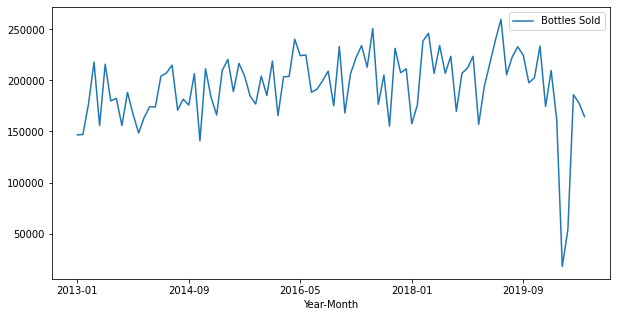

In [ ]:
features_dataframe.groupby(by=['Year-Month']).agg({'Bottles Sold': np.sum}).plot(figsize=(10, 5))

All three models have similar predictive performance. Therefore, we would recommend using the linear regression model, for simplicity.

## Results and discussion<a name='results'></a>

Our analysis show how relatively easy we can build a machine learning model to help us with our decisions for restocking our store inventory.

First, we identified our business problem. We tried to predict our monthly sales by using historical sales and weather data. The historical sales data is our own, and there would be no need to query an external source for it; a store has records of its sales. The weather data was freely available for download from the [NOAA's Global Historical Climatology Network (GHCN)](https://console.cloud.google.com/marketplace/details/noaa-public/ghcn-d).

GHCN maintains a vastly complex database of weather information, and we needed quite some time to be able find the relevant data for us. We had to find the weather stations that are in the vicinity of the store, which are still operating in 2020 (some of stations had data going back to the 1700s!) and are recording the weather information that we need, that is temperature, snowfall and precipitation.

Once we found the station closest to us, we queried its data and merged it with our historical sales to obtain our final data set that is ready for modeling.

Then, we apply three regression models: linear, Ridge and Lasso. All models exhibit similar predictive performance, and we recommend using the linear regression for its simplicity.

The models perform rather good, with their R-squared values ranging around 0.88.

As everything in the world, the model's performance suffered substantially when trying to predict sales for the period of the COVID-19 pandemic in the U.S. (April and May 2020). The sales for this period drop very low, something that has not been observed in our data set and could not have been modeled by any other machine model.

## Conclusion<a name='conclusion'></a>

To conclude this work, I will say a few words about the application of this project.

Predict store sales based on historical data is very common and known retail problem and there are already some very known solutions to it. In general, a store owner could just export his data to a machine learning expert, and have him return his predictions. He would then use this data to make decision on restocking his inventory.

This notebook served more as an education tool for me, than as a real-world project that can be applied. I am not saying that this does not have to potential or that it can not be implemented in an actual case study, but I am having a hard time believing that a store owner from Iowa would trust my work.

Maybe I will show it to some local stores in my country (Macedonia), and see if there is any interest to see this work being applied here.